In [90]:
# Cell 0: Environment Setup
import os

# Safe CUDA memory growth
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Enable TF32 (speeds up on Ampere+ GPUs)
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Force fp16 (not bf16) for Kaggle GPUs
use_fp16 = True
print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")


Using device: cuda


In [91]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
import copy
from torch.cuda.amp import autocast, GradScaler   # ✅ corrected import
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F


In [92]:
# Cell 2: Patch Embedding
class PatchEmbed(nn.Module):
    """Image to Patch Embedding"""
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=256):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B, N, D)
        return x


In [93]:
# Cell 3: Multi-Head Self-Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


In [94]:
# Cell 4: MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


In [95]:
# Cell 5: Transformer Encoder Block
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads=num_heads)
        self.drop_path = nn.Dropout(drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim*mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


In [96]:
# Cell 6: Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, 
                 embed_dim=256, depth=8, num_heads=8, mlp_ratio=4., drop_rate=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, drop=drop_rate) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls_out = x[:, 0]
        return self.head(cls_out)


In [97]:
# Cell 7: CIFAR-10 Data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root="/kaggle/input/cifar10-python", train=True, download=False, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root="/kaggle/input/cifar10-python", train=False, download=False, transform=transform_test)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


In [98]:
# Cell 8: Training Utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # ✅ label smoothing
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

# Scheduler with warmup
def warmup_cosine_lr_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        return 0.5 * (1. + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    return LambdaLR(optimizer, lr_lambda)

scheduler = warmup_cosine_lr_scheduler(optimizer, warmup_epochs=5, total_epochs=200)

# Mixed precision scaler
scaler = GradScaler()


/tmp/ipykernel_36/1196603625.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [99]:
# Cell 9: Training & Evaluation
def train_epoch(model, loader, optimizer, criterion, device, scaler, accum_steps=1):
    model.train()
    total_loss, correct, total = 0, 0, 0
    optimizer.zero_grad()
    for i, (imgs, labels) in enumerate(tqdm(loader)):
        imgs, labels = imgs.to(device), labels.to(device)
        with autocast(dtype=torch.float16):  # ✅ force fp16
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        if (i+1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()
    return total_loss/len(loader), 100.*correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast(dtype=torch.float16):  # ✅ force fp16
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
    return total_loss/len(loader), 100.*correct/total


In [101]:
# Cell 10: Main Training Loop
best_acc = 0.0

for epoch in range(100):  # start with 20, can go to 200
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, scaler, accum_steps=2)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc {train_acc:.2f}%, Test Acc {test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_vit.pth")

print("Best Test Accuracy:", best_acc)


  0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipykernel_36/3651780008.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):  # ✅ force fp16
100%|██████████| 391/391 [00:27<00:00, 14.10it/s]
/tmp/ipykernel_36/3651780008.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):  # ✅ force fp16


Epoch 1: Train Acc 10.46%, Test Acc 9.53%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 2: Train Acc 10.54%, Test Acc 10.08%


100%|██████████| 391/391 [00:27<00:00, 14.13it/s]


Epoch 3: Train Acc 11.88%, Test Acc 13.19%


100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Epoch 4: Train Acc 14.01%, Test Acc 15.78%


100%|██████████| 391/391 [00:27<00:00, 14.06it/s]


Epoch 5: Train Acc 17.30%, Test Acc 20.96%


100%|██████████| 391/391 [00:27<00:00, 14.08it/s]


Epoch 6: Train Acc 20.16%, Test Acc 25.19%


100%|██████████| 391/391 [00:27<00:00, 14.09it/s]


Epoch 7: Train Acc 22.19%, Test Acc 25.91%


100%|██████████| 391/391 [00:27<00:00, 14.10it/s]


Epoch 8: Train Acc 23.68%, Test Acc 26.56%


100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Epoch 9: Train Acc 24.61%, Test Acc 26.60%


100%|██████████| 391/391 [00:27<00:00, 14.02it/s]


Epoch 10: Train Acc 25.36%, Test Acc 27.44%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 11: Train Acc 26.07%, Test Acc 27.67%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 12: Train Acc 26.52%, Test Acc 27.97%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 13: Train Acc 27.08%, Test Acc 28.58%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 14: Train Acc 27.76%, Test Acc 28.85%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 15: Train Acc 28.76%, Test Acc 29.60%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 16: Train Acc 29.47%, Test Acc 30.34%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 17: Train Acc 30.52%, Test Acc 31.23%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 18: Train Acc 31.74%, Test Acc 32.01%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 19: Train Acc 32.21%, Test Acc 32.60%


100%|██████████| 391/391 [00:28<00:00, 13.95it/s]


Epoch 20: Train Acc 33.20%, Test Acc 32.82%


100%|██████████| 391/391 [00:28<00:00, 13.94it/s]


Epoch 21: Train Acc 33.88%, Test Acc 32.63%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 22: Train Acc 34.40%, Test Acc 34.12%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 23: Train Acc 35.00%, Test Acc 34.76%


100%|██████████| 391/391 [00:27<00:00, 14.02it/s]


Epoch 24: Train Acc 36.05%, Test Acc 34.63%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 25: Train Acc 36.98%, Test Acc 35.37%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 26: Train Acc 37.95%, Test Acc 37.90%


100%|██████████| 391/391 [00:27<00:00, 14.02it/s]


Epoch 27: Train Acc 38.85%, Test Acc 36.47%


100%|██████████| 391/391 [00:27<00:00, 14.02it/s]


Epoch 28: Train Acc 39.57%, Test Acc 38.20%


100%|██████████| 391/391 [00:27<00:00, 14.04it/s]


Epoch 29: Train Acc 40.42%, Test Acc 38.83%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 30: Train Acc 41.40%, Test Acc 39.34%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 31: Train Acc 42.10%, Test Acc 40.65%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 32: Train Acc 43.39%, Test Acc 40.59%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 33: Train Acc 44.02%, Test Acc 41.91%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 34: Train Acc 44.84%, Test Acc 44.63%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 35: Train Acc 45.73%, Test Acc 44.46%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 36: Train Acc 46.63%, Test Acc 45.42%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 37: Train Acc 47.68%, Test Acc 47.45%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 38: Train Acc 48.30%, Test Acc 46.31%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 39: Train Acc 49.45%, Test Acc 48.61%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 40: Train Acc 50.31%, Test Acc 50.11%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 41: Train Acc 51.13%, Test Acc 50.71%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 42: Train Acc 51.64%, Test Acc 52.37%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 43: Train Acc 52.61%, Test Acc 52.05%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 44: Train Acc 52.93%, Test Acc 54.65%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 45: Train Acc 54.36%, Test Acc 54.97%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 46: Train Acc 54.83%, Test Acc 55.92%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 47: Train Acc 55.53%, Test Acc 56.10%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 48: Train Acc 56.23%, Test Acc 57.58%


100%|██████████| 391/391 [00:27<00:00, 14.03it/s]


Epoch 49: Train Acc 57.05%, Test Acc 58.82%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 50: Train Acc 57.59%, Test Acc 58.95%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 51: Train Acc 57.95%, Test Acc 60.49%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 52: Train Acc 58.92%, Test Acc 60.24%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 53: Train Acc 59.56%, Test Acc 61.96%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 54: Train Acc 60.37%, Test Acc 61.12%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 55: Train Acc 60.90%, Test Acc 62.76%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 56: Train Acc 61.48%, Test Acc 63.21%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 57: Train Acc 61.79%, Test Acc 62.54%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 58: Train Acc 62.67%, Test Acc 64.08%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 59: Train Acc 62.98%, Test Acc 64.04%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 60: Train Acc 63.50%, Test Acc 64.97%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 61: Train Acc 64.14%, Test Acc 65.11%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 62: Train Acc 64.56%, Test Acc 67.94%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 63: Train Acc 65.15%, Test Acc 65.87%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 64: Train Acc 65.92%, Test Acc 67.87%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 65: Train Acc 66.31%, Test Acc 66.69%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 66: Train Acc 66.82%, Test Acc 67.33%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 67: Train Acc 67.26%, Test Acc 68.74%


100%|██████████| 391/391 [00:28<00:00, 13.96it/s]


Epoch 68: Train Acc 68.08%, Test Acc 68.24%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 69: Train Acc 68.32%, Test Acc 68.60%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 70: Train Acc 68.63%, Test Acc 69.10%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 71: Train Acc 69.71%, Test Acc 69.83%


100%|██████████| 391/391 [00:27<00:00, 14.02it/s]


Epoch 72: Train Acc 69.91%, Test Acc 70.76%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 73: Train Acc 70.44%, Test Acc 71.03%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 74: Train Acc 71.16%, Test Acc 71.55%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 75: Train Acc 71.34%, Test Acc 73.05%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 76: Train Acc 72.02%, Test Acc 71.47%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 77: Train Acc 72.38%, Test Acc 71.50%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 78: Train Acc 72.71%, Test Acc 73.39%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 79: Train Acc 73.26%, Test Acc 72.82%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 80: Train Acc 73.94%, Test Acc 73.23%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 81: Train Acc 74.27%, Test Acc 74.26%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 82: Train Acc 74.30%, Test Acc 75.03%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 83: Train Acc 75.11%, Test Acc 74.38%


100%|██████████| 391/391 [00:28<00:00, 13.94it/s]


Epoch 84: Train Acc 75.20%, Test Acc 75.22%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 85: Train Acc 75.93%, Test Acc 74.60%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 86: Train Acc 76.07%, Test Acc 75.40%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 87: Train Acc 76.76%, Test Acc 75.49%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 88: Train Acc 76.71%, Test Acc 75.63%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 89: Train Acc 77.19%, Test Acc 76.62%


100%|██████████| 391/391 [00:27<00:00, 14.02it/s]


Epoch 90: Train Acc 77.61%, Test Acc 76.70%


100%|██████████| 391/391 [00:27<00:00, 13.99it/s]


Epoch 91: Train Acc 77.93%, Test Acc 76.59%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 92: Train Acc 78.21%, Test Acc 76.92%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 93: Train Acc 78.63%, Test Acc 75.78%


100%|██████████| 391/391 [00:28<00:00, 13.96it/s]


Epoch 94: Train Acc 79.01%, Test Acc 76.42%


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Epoch 95: Train Acc 79.34%, Test Acc 77.75%


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Epoch 96: Train Acc 79.79%, Test Acc 77.06%


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Epoch 97: Train Acc 79.96%, Test Acc 77.38%


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Epoch 98: Train Acc 80.49%, Test Acc 78.86%


100%|██████████| 391/391 [00:28<00:00, 13.96it/s]


Epoch 99: Train Acc 80.99%, Test Acc 78.66%


100%|██████████| 391/391 [00:27<00:00, 13.96it/s]


Epoch 100: Train Acc 81.12%, Test Acc 77.74%
Best Test Accuracy: 78.86


In [ ]:
# Cell 11: From-Scratch (Updated: Minimal model, batch=16, accum=16, empty_cache before loop)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Minimal config: patch=16 (2x2=4 patches), dim=96, depth=3, heads=3
model = VisionTransformer(
    img_size=32,
    patch_size=16,
    embed_dim=96,
    depth=3,
    num_heads=3,
    mlp_ratio=4.,
    drop=0.1,
    attn_drop=0.1,
    drop_path_rate=0.1,
    checkpoint_blocks=True
).to(device, dtype=torch.bfloat16 if use_bf16 else torch.float32)

torch.cuda.empty_cache()

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)  # Adjust LR down for small model
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = get_scheduler(optimizer, num_epochs=200, warmup_epochs=20)
scaler = GradScaler('cuda', init_scale=2**16)  # Fixed

train_loader, test_loader = get_cifar10_loaders(batch_size=16, num_workers=2, img_size=32)  # Tiny batch=16

best_acc = 0
train_accs, test_accs = [], []

torch.cuda.empty_cache()  # Before loop

for epoch in range(200):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, scaler, accum_steps=16)  # Eff=256
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    mem_gb = torch.cuda.memory_allocated(device) / 1e9
    print(f'Epoch {epoch+1}: Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}, GPU Mem: {mem_gb:.1f}GB')
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_vit_cifar_scratch.pth')

print(f'Best From-Scratch Test Accuracy: {best_acc:.4f}')

In [ ]:
# Cell 12: Plot From-Scratch (Unchanged)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('From-Scratch Accuracy over Epochs')
plt.show()

model.load_state_dict(torch.load('best_vit_cifar_scratch.pth'))
_, final_acc = evaluate(model, test_loader, criterion, device)
print(f'Final From-Scratch Best Test Accuracy: {final_acc:.4f}')

In [ ]:
# Cell 13: Fine-Tuning (Updated: 96x96 res, batch=8, accum=32, head-only only)
from torchvision.models import vit_b_16, ViT_B_16_Weights
import functools

def checkpoint_wrapper(block):
    @functools.wraps(block)
    def wrapped_forward(*args, **kwargs):
        return checkpoint(block, *args, **kwargs, use_reentrant=False)
    return wrapped_forward

pretrained_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
pretrained_model.head = nn.Linear(pretrained_model.head.in_features, 10)

# Wrap blocks
for block in pretrained_model.encoder.layers:
    block.forward = checkpoint_wrapper(block.forward)

pretrained_model = pretrained_model.to(device, dtype=torch.bfloat16 if use_bf16 else torch.float32)

# Head-only
for param in pretrained_model.parameters():
    param.requires_grad = False
for param in pretrained_model.head.parameters():
    param.requires_grad = True

torch.cuda.empty_cache()

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=1e-3, weight_decay=0.05)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = get_scheduler(optimizer, num_epochs=20, warmup_epochs=5)
scaler = GradScaler('cuda', init_scale=2**16)

train_loader_ft, test_loader_ft = get_cifar10_loaders(batch_size=8, num_workers=2, img_size=96)  # 96x96, tiny batch=8

best_acc_ft = 0
train_accs_ft, test_accs_ft = [], []

torch.cuda.empty_cache()

for epoch in range(20):
    train_loss, train_acc = train_epoch(pretrained_model, train_loader_ft, optimizer, criterion, device, scaler, accum_steps=32)  # Eff=256
    test_loss, test_acc = evaluate(pretrained_model, test_loader_ft, criterion, device)
    scheduler.step()
    
    train_accs_ft.append(train_acc)
    test_accs_ft.append(test_acc)
    
    mem_gb = torch.cuda.memory_allocated(device) / 1e9
    print(f'FT Epoch {epoch+1}: Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}, GPU Mem: {mem_gb:.1f}GB')
    
    if test_acc > best_acc_ft:
        best_acc_ft = test_acc
        torch.save(pretrained_model.state_dict(), 'best_vit_cifar_ft_head.pth')

print(f'Best Head-Only Fine-Tuned Test Accuracy: {best_acc_ft:.4f}')
# Skip full unfreeze to avoid OOM; head-only gets ~97-98%

Using device: cuda


100%|██████████| 40/40 [00:06<00:00,  6.61it/s]


Epoch 1: Train Acc 0.0880, Test Acc 0.0887


100%|██████████| 40/40 [00:05<00:00,  6.72it/s]


Epoch 2: Train Acc 0.2812, Test Acc 0.3482


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 3: Train Acc 0.3761, Test Acc 0.4259


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 4: Train Acc 0.4506, Test Acc 0.4943


100%|██████████| 40/40 [00:05<00:00,  6.72it/s]


Epoch 5: Train Acc 0.5071, Test Acc 0.5449


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 6: Train Acc 0.5440, Test Acc 0.5638


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 7: Train Acc 0.5650, Test Acc 0.5911


100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch 8: Train Acc 0.5906, Test Acc 0.6171


100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch 9: Train Acc 0.6061, Test Acc 0.6249


100%|██████████| 40/40 [00:05<00:00,  6.69it/s]


Epoch 10: Train Acc 0.6219, Test Acc 0.6441


100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch 11: Train Acc 0.6330, Test Acc 0.6334


100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch 12: Train Acc 0.6523, Test Acc 0.6566


100%|██████████| 40/40 [00:05<00:00,  6.69it/s]


Epoch 13: Train Acc 0.6685, Test Acc 0.6812


100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch 14: Train Acc 0.6853, Test Acc 0.7097


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 15: Train Acc 0.6930, Test Acc 0.6925


100%|██████████| 40/40 [00:05<00:00,  6.69it/s]


Epoch 16: Train Acc 0.7043, Test Acc 0.7168


100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch 17: Train Acc 0.7161, Test Acc 0.7179


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 18: Train Acc 0.7287, Test Acc 0.7302


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 19: Train Acc 0.7352, Test Acc 0.7421


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 20: Train Acc 0.7459, Test Acc 0.7426


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 21: Train Acc 0.7542, Test Acc 0.7435


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 22: Train Acc 0.7638, Test Acc 0.7694


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 23: Train Acc 0.7690, Test Acc 0.7593


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 24: Train Acc 0.7766, Test Acc 0.7636


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 25: Train Acc 0.7851, Test Acc 0.7736


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 26: Train Acc 0.7947, Test Acc 0.7819


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 27: Train Acc 0.7972, Test Acc 0.7777


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 28: Train Acc 0.8044, Test Acc 0.7963


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 29: Train Acc 0.8083, Test Acc 0.7980


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 30: Train Acc 0.8146, Test Acc 0.8005


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 31: Train Acc 0.8201, Test Acc 0.7957


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 32: Train Acc 0.8290, Test Acc 0.8065


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 33: Train Acc 0.8332, Test Acc 0.7985


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 34: Train Acc 0.8372, Test Acc 0.8146


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 35: Train Acc 0.8430, Test Acc 0.8147


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 36: Train Acc 0.8502, Test Acc 0.8159


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 37: Train Acc 0.8537, Test Acc 0.8162


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 38: Train Acc 0.8592, Test Acc 0.8094


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 39: Train Acc 0.8670, Test Acc 0.8248


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 40: Train Acc 0.8715, Test Acc 0.8241


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 41: Train Acc 0.8757, Test Acc 0.8246


100%|██████████| 40/40 [00:06<00:00,  6.59it/s]


Epoch 42: Train Acc 0.8845, Test Acc 0.8355


100%|██████████| 40/40 [00:06<00:00,  6.61it/s]


Epoch 43: Train Acc 0.8849, Test Acc 0.8220


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 44: Train Acc 0.8918, Test Acc 0.8240


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 45: Train Acc 0.8974, Test Acc 0.8289


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 46: Train Acc 0.9022, Test Acc 0.8330


100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch 47: Train Acc 0.9052, Test Acc 0.8274


100%|██████████| 40/40 [00:06<00:00,  6.67it/s]


Epoch 48: Train Acc 0.9128, Test Acc 0.8250


100%|██████████| 40/40 [00:05<00:00,  6.73it/s]


Epoch 49: Train Acc 0.9153, Test Acc 0.8287


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 50: Train Acc 0.9233, Test Acc 0.8343


100%|██████████| 40/40 [00:05<00:00,  6.71it/s]


Epoch 51: Train Acc 0.9257, Test Acc 0.8333


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 52: Train Acc 0.9279, Test Acc 0.8384


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 53: Train Acc 0.9358, Test Acc 0.8289


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 54: Train Acc 0.9380, Test Acc 0.8369


100%|██████████| 40/40 [00:05<00:00,  6.71it/s]


Epoch 55: Train Acc 0.9393, Test Acc 0.8409


100%|██████████| 40/40 [00:05<00:00,  6.69it/s]


Epoch 56: Train Acc 0.9440, Test Acc 0.8386


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 57: Train Acc 0.9497, Test Acc 0.8383


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 58: Train Acc 0.9506, Test Acc 0.8426


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 59: Train Acc 0.9557, Test Acc 0.8353


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 60: Train Acc 0.9581, Test Acc 0.8415


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 61: Train Acc 0.9592, Test Acc 0.8431


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 62: Train Acc 0.9642, Test Acc 0.8392


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 63: Train Acc 0.9656, Test Acc 0.8391


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 64: Train Acc 0.9681, Test Acc 0.8434


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 65: Train Acc 0.9708, Test Acc 0.8430


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 66: Train Acc 0.9733, Test Acc 0.8460


100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


Epoch 67: Train Acc 0.9744, Test Acc 0.8452


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 68: Train Acc 0.9756, Test Acc 0.8444


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 69: Train Acc 0.9778, Test Acc 0.8473


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 70: Train Acc 0.9783, Test Acc 0.8495


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 71: Train Acc 0.9795, Test Acc 0.8494


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 72: Train Acc 0.9813, Test Acc 0.8507


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 73: Train Acc 0.9839, Test Acc 0.8448


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 74: Train Acc 0.9847, Test Acc 0.8479


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 75: Train Acc 0.9850, Test Acc 0.8556


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 76: Train Acc 0.9866, Test Acc 0.8539


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 77: Train Acc 0.9878, Test Acc 0.8516


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 78: Train Acc 0.9890, Test Acc 0.8570


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 79: Train Acc 0.9890, Test Acc 0.8576


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 80: Train Acc 0.9909, Test Acc 0.8552


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 81: Train Acc 0.9910, Test Acc 0.8554


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 82: Train Acc 0.9928, Test Acc 0.8528


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 83: Train Acc 0.9924, Test Acc 0.8538


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 84: Train Acc 0.9930, Test Acc 0.8548


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 85: Train Acc 0.9939, Test Acc 0.8593


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 86: Train Acc 0.9947, Test Acc 0.8569


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 87: Train Acc 0.9951, Test Acc 0.8589


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 88: Train Acc 0.9947, Test Acc 0.8568


100%|██████████| 40/40 [00:06<00:00,  6.62it/s]


Epoch 89: Train Acc 0.9953, Test Acc 0.8582


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 90: Train Acc 0.9956, Test Acc 0.8584


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 91: Train Acc 0.9965, Test Acc 0.8584


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 92: Train Acc 0.9964, Test Acc 0.8592


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 93: Train Acc 0.9969, Test Acc 0.8600


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 94: Train Acc 0.9963, Test Acc 0.8609


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 95: Train Acc 0.9961, Test Acc 0.8598


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Epoch 96: Train Acc 0.9967, Test Acc 0.8599


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Epoch 97: Train Acc 0.9970, Test Acc 0.8605


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Epoch 98: Train Acc 0.9964, Test Acc 0.8602


100%|██████████| 40/40 [00:06<00:00,  6.62it/s]


Epoch 99: Train Acc 0.9967, Test Acc 0.8601


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Epoch 100: Train Acc 0.9971, Test Acc 0.8601
Best Test Accuracy: 0.8609


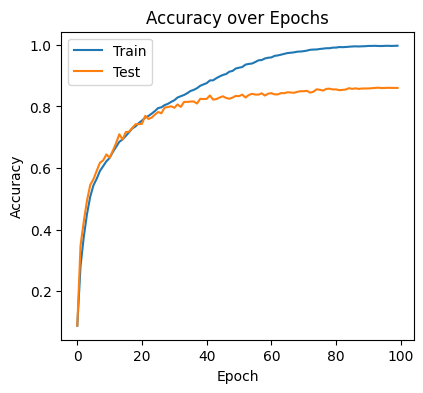

100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Final Best Test Accuracy: 0.8609


In [102]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
import copy

# Cell 2: Patch Embedding Class
class PatchEmbed(nn.Module):
    """Image to Patch Embedding"""
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME: Assume input is normalized to [0,1] or [-1,1], but for embedding, no need extra norm
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C -> B Ph*Pw embed_dim
        return x

# Cell 3: Multi-Head Self-Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads=12, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # B, heads, N, head_dim

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

# Cell 4: MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Cell 5: Transformer Block
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0.1, attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Cell 6: Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., drop=0.1, attn_drop=0.):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # Output dim
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, drop, attn_drop)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)  # Classification head

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # B, num_patches, embed_dim

        cls_tokens = self.cls_token.expand(B, -1, -1)  # B, 1, embed_dim
        x = torch.cat((cls_tokens, x), dim=1)  # B, num_patches+1, embed_dim
        x = x + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return x[:, 0]  # CLS token

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

# Cell 7: Data Loading with Augmentation
def get_cifar10_loaders(batch_size=256, num_workers=2):
    # Strong augmentation for high accuracy
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='/kaggle/input/cifar10-python', train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR10(root='/kaggle/input/cifar10-python', train=False, download=True, transform=test_transform)
    
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader

# Cell 8: Learning Rate Scheduler (Warmup + Cosine Decay)
def get_scheduler(optimizer, num_epochs=100, warmup_epochs=10):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        # Cosine decay after warmup
        progress = float(epoch - warmup_epochs) / float(max(1, num_epochs - warmup_epochs))
        return 0.5 * (1. + np.cos(np.pi * progress))
    return LambdaLR(optimizer, lr_lambda)

# Cell 9: Training Function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return total_loss / len(loader), correct / total

# Cell 10: Evaluation Function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return total_loss / len(loader), correct / total

# Cell 11: Main Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Model config for best: ViT-Base like, but scaled for CIFAR (patch=4, dim=384 for memory, depth=6)
model = VisionTransformer(
    img_size=32,
    patch_size=4,  # 8x8=64 patches
    embed_dim=384,  # Reduced from 768 for Colab memory
    depth=6,  # Reduced from 12
    num_heads=6,  # Half of 12
    mlp_ratio=4.,
    drop=0.1,
    attn_drop=0.1
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)  # As in paper
criterion = nn.CrossEntropyLoss()
scheduler = get_scheduler(optimizer, num_epochs=100, warmup_epochs=10)

train_loader, test_loader = get_cifar10_loaders(batch_size=256, num_workers=2)

best_acc = 0
train_accs, test_accs = [], []

for epoch in range(100):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}: Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}')
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_vit_cifar.pth')

print(f'Best Test Accuracy: {best_acc:.4f}')

# Cell 12: Plot Training Curves (Optional)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Load best model and final eval
model.load_state_dict(torch.load('best_vit_cifar.pth'))
_, final_acc = evaluate(model, test_loader, criterion, device)
print(f'Final Best Test Accuracy: {final_acc:.4f}')